<a href="https://colab.research.google.com/github/mwbest/CofI_2024/blob/master/asta_singleslit_H17_47_0037_0723.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cloning and Installing.**

---
- Cloning pykosmos from Jim Davenport's GitHub page and installing necessary packages.
- Cloning functions that are additions and modifications to Jim Davenport's and CCD Data Reduction Guide's functions, written by The College of Idaho undergraduate students Julene Elias, Abdullah Korra, Anna Panova, Asta Shakti Suman Sharma, and Ignasi Bonmati Gonzalvez under the mentorship of professor Dr. Katie Devine.

In [81]:
!git clone https://github.com/jradavenport/pykosmos.git
!git clone https://github.com/mwbest/cofi-kosmos-pipe-funcs.git
!pip install specutils
!pip install ccdproc
!pip install specreduce

fatal: destination path 'pykosmos' already exists and is not an empty directory.
fatal: destination path 'cofi-kosmos-pipe-funcs' already exists and is not an empty directory.


####**Configuring Matplotlib and Importing Libraries. Adding Custom Modules to Python Path and then import them.**

---

In [82]:
# Making all necessary imports.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ccdproc import CCDData
from ccdproc import Combiner, trim_image
from ccdproc import cosmicray_lacosmic
from specutils import Spectrum1D
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy.io import fits
import sys
sys.path.append("/content/pykosmos")
sys.path.append("/content/cofi-kosmos-pipe-funcs")
import CofI_KOSMOS as pipe
from pykosmos import pykosmos

**Mounting Google Drive**

---

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setting the variable "DISPLAY" to boolean True. "DISPLAY" will be used throughout the pipeline.**

---

In [84]:
DISPLAY = True

## **Bias**

---
Creating an array of all bias files to work with.
The code below creates a text file that contains all the bias files in our particular data.

In [85]:
directory_orig = "/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/"
with open('biaslist.txt', 'w') as f:
    for num in range(74,79):
      f.write("Bias.00{}.fits".format(num) + "\n")
    #f.write("Bias.0076.fits" + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
biasfiles_i = pd.read_table("biaslist.txt", names = ['impath'])
# Returning an array of the bias files.
biasfiles = directory_orig + biasfiles_i['impath'].values
biasfiles

array(['/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Bias.0074.fits',
       '/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Bias.0075.fits',
       '/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Bias.0076.fits',
       '/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Bias.0077.fits',
       '/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Bias.0078.fits'],
      dtype=object)

###**Combining bias files and displaying the combined bias frame.**

---
Using Jim Davenport's "pykosmos.biascombine" function to combine bias frames.

In [86]:
bias = pykosmos.biascombine(biasfiles)
# Creating a path object to use throughout the pipeline.
directory_new = "/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037/"
path = Path(directory_new)
# Choosing file name.
filename = 'bias_combined.fits'
# The code below saves the combined bias frame as a "fits" file.
# Please make sure to run the following block of code (until the next comment) only once,
# otherwise, you will be attempting to save a file that already exists.
# Thus, please comment this block of code out once you run it.
hdu = fits.PrimaryHDU(bias)
hdu.writeto(path / filename, overwrite = True)

 [astropy.io.fits.verify]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.



**The code below plots the combined bias frame. RUN, if the user wants to see how the combined bias frame looks.** [OPTIONAL]

In [87]:
plt.imshow(bias, origin ='lower',aspect ='auto',cmap = plt.cm.gray)
plt.title('median bias frame')
plt.clim(np.percentile(bias, (5, 98)))
cb = plt.colorbar()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


###**Combining dark files and displaying the combined dark frame.**

---
Using Jim Davenport's "pykosmos.darkcombine" function to combine bias frames.
The code below creates a text file that contains all the dark files in our particular data.

In [88]:
with open('darklist_def.txt', 'w') as f9:
    for num in range(91,94):
      f9.write("dark.00{}.fits".format(num) + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the dark files.
darkfiles_i_def = pd.read_table("darklist_def.txt", names = ['impath'])
darkfiles_def = directory_orig + darkfiles_i_def['impath'].values
# Using "darkcombine" function defined above, combining the dark files.
new_darks = pipe.darkcombine(darkfiles_def,bias =
"/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037/bias_combined.fits",
directory = "/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037/", trim = False)

**The code below plots the combined dark frame. RUN, if the user wants to see how the combined bias frame looks.** [OPTIONAL]

In [89]:
plt.imshow(new_darks, origin = 'lower',aspect = 'auto',cmap = plt.cm.gray)
plt.title('median dark frame')
plt.clim(np.percentile(new_darks, (5, 98)))
cb = plt.colorbar()

## **Histogram of dark pixel values for combined dark frame with Poisson and Gaussian distributions fitted**

---
The code in this section is for analyzing the need to use dark frames in data reduction.

*If the histogram follows Gaussian distribution, there is no need to subtract darks. If the histogram follows Poisson distribution, darks need to be subtracted.*

**Plotting histogram of dark pixel values in combined dark frame with Poisson and Gaussian distributions fitted. RUN, if the user wants to see how the distribution looks.** [OPTIONAL]


---
*The following data is from APO KOSMOS Documentation (it is specific to the data used in this pipeline):`https://www.apo.nmsu.edu/arc35m/Instruments/KOSMOS/userguide.html` Section 3.2 Detector Characteristics. The user can find gain and read noise values in the instrument documentation and exposure time in the image header or in the observing log.*

In [90]:
gain = 0.6
exposure = 300 # in seconds
read_noise = 6
# Computing and printing out the dark current using mean of combined dark frame.
mean_dark = np.mean(new_darks.data)
dark_rate = mean_dark * gain / exposure
print(dark_rate)
# Plotting histogram of dark pixel values with Poisson and Gaussian distributions fitted.
dark_hist = pipe.plot_dark_with_distributions(image = new_darks.data, rn = read_noise, dark_rate = dark_rate,
                                       exposure = exposure, gain = gain)

0.11022335525597939


## **Flats**

---
Creating an array of all red flats to work with (the science image in this pipeline has red disperser). The user should use the flats taken with the disperser that matches the science image.

The code below creates a text file that contains all the red flat files in our particular data.

In [91]:
with open('Flat_SEG3R1.txt', 'w') as f2:
    for num in range(39,40):
      f2.write("Flat_SEG3R1.0039.fits".format(num) + "\n")
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the red flat files.
redflatfiles_i = pd.read_table("Flat_SEG3R1.txt", names = ['impath'])
redflatfiles = directory_orig + redflatfiles_i['impath'].values
redflatfiles

array(['/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/Flat_SEG3R1.0039.fits'],
      dtype=object)

**Looping through every red flat file from the array of red flat files and appending "DATASEC" keyword to its header.**

---

*If using, ideally run the following block of code only once,
otherwise the keyword will be appended to the header every time you run it.*

In [92]:
for redflatfile in redflatfiles:
  hdul = fits.open(redflatfile,'update')  # open a FITS file
  hdr = hdul[0].header
  hdr.append("DATASEC")
  hdr["DATASEC"] = "[1:2048,1:4096]"
  hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
  hdul.writeto(redflatfile, overwrite = True)

**Wrapper around Combiner, the spectral response normalization, and the illumination correction.**

---

This should work WITH or WITHOUT bias. Combining all red flats and displaying combined red flat frame (darks are not subtracted, because they are not useful for data in this pipeline). The user should include the "dark" parameter if darks need to be subtracted.

In [93]:
# Combining the red flat files using the "flatcombine" function defined above and plotting the combined red flat frame.
redflat_darknotsub, redilum_darknotsub = pipe.flatcombine(redflatfiles, bias = bias, Saxis = 1, Waxis = 0)
plt.imshow(redflat_darknotsub, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(.9,1.1)
plt.title('median red flat')
cb = plt.colorbar()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:overwriting masked ndarray's current mask with specified mask.


INFO: overwriting masked ndarray's current mask with specified mask. [astropy.nddata.nddata]


/usr/local/lib/python3.10/dist-packages/ccdproc/combiner.py:443: RuntimeWarning: All-NaN slice encountered
  medianed = median_func(data, axis=0)
/usr/local/lib/python3.10/dist-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/usr/local/lib/python3.10/dist-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## **Raw Science Image processed with "apo_proc".**

---
Reducing science image with "apo_proc" function defined above (not subtracting darks) and plotting the resulting image. Again, the user should subtract darks if needed (just by adding the "dark" parameter) and, in this case, use flats from which darks were subtracted.

In [94]:
# Opening the science image as a "fits" file object.
sci = directory_orig + 'H17_47.0037.fits'
hdul = fits.open(sci, 'update')
hdr = hdul[0].header
hdr.append("DATASEC")
hdr["DATASEC"] = "[1:2048,1:4096]"
hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
hdul.writeto(sci, overwrite = True)
# Using "apo_proc" function defined above to reduce the science image.
sciimg = pipe.apo_proc(sci, bias = bias, ilum = redilum_darknotsub, flat = redflat_darknotsub, Saxis = 1, Waxis =0, CR = False)
# Plotting the resulting science image.
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim(1,0)
plt.colorbar()
plt.title(sci)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Text(0.5, 1.0, '/content/drive/MyDrive/RAISE Student Research/Group Resources/UT230909/H17_47.0037.fits')

## **Identifying hot pixels**

---
This block of code trims each dark frame, writes the trimmed
dark frames into text file `"darkfiles_trimmed.txt"`, and saves them in the directory provided by the user in the "darkcombine" function.

In [95]:
with open('darkfiles_trimmed.txt', 'w') as f:
      count = 1
      for darkfile in darkfiles_def:
        hdul = fits.open(darkfile, 'update')
        hdr = hdul[0].header
        # Please make sure to run the following block of code (until the next comment) only once,
        # otherwise, you will be appending "DATASEC" keyword each run, making unsuccessful attempts to remove cards
        # from the header that have already been removed, and saving files that already exist.
        # Thus, please comment this block of code out once you run it.
        # The keywords removed from the header in this code are specific to the particular data used in this pipeline.
        # If you have cards that are not in the "fits" format, just replace the keywords in this pipeline with yours.
        # Otherwise, the following two lines will not be needed.
        for key in ["CD1_1", "CD1_2", "CD2_1", "CD2_2"]:
          if key in hdr:
            hdr.remove(key)
        hdr.append("DATASEC")
        hdr["DATASEC"] = "[1:2048,1:4096]"
        hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
        hdul.writeto(darkfile, overwrite = True)
        trimmed_darkfile = pipe.apo_proc(darkfile, ilum = redilum_darknotsub, Saxis = 1, Waxis =0)
        f.write("trimmed_darkfile{}.fits".format(count) + "\n")
        filename = "trimmed_darkfile{}.fits".format(count)
        hdu = fits.PrimaryHDU(trimmed_darkfile)
        hdu.writeto(path/filename, overwrite = True)
        count += 1
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the trimmed dark frames.
trimmed_darkfiles_i = pd.read_table("darkfiles_trimmed.txt", names = ['impath'])
trimmed_darkfiles = directory_new +'/'+ trimmed_darkfiles_i['impath'].values
# Create a list of each frame's dark current by looping through the trimmed dark images,
# calculating the dark current, and appending it to the list.
dark_current_list = []
count = 1
for trimmed_darkfile in trimmed_darkfiles:
  hdul = fits.open(trimmed_darkfile)
  dark_current = hdul[0].data * (gain * u.electron / u.adu) / (exposure * u.second)
  dark_current_list.append(dark_current)
  count += 1

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


#### **Enabling interactivity with the widgets**

---
*If you ever want to disable it, use the following: `output.disable_custom_widget_manager()`*

In [96]:
# Use this code to enable interaction with the widget:
!pip install ipympl
!pip install ipywidgets
!pip install matplotlib
!pip install mpl-interactions
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
from google.colab import output
output.enable_custom_widget_manager()

**Plotting a Histograms of dark currents.** [OPTIONAL]

[]

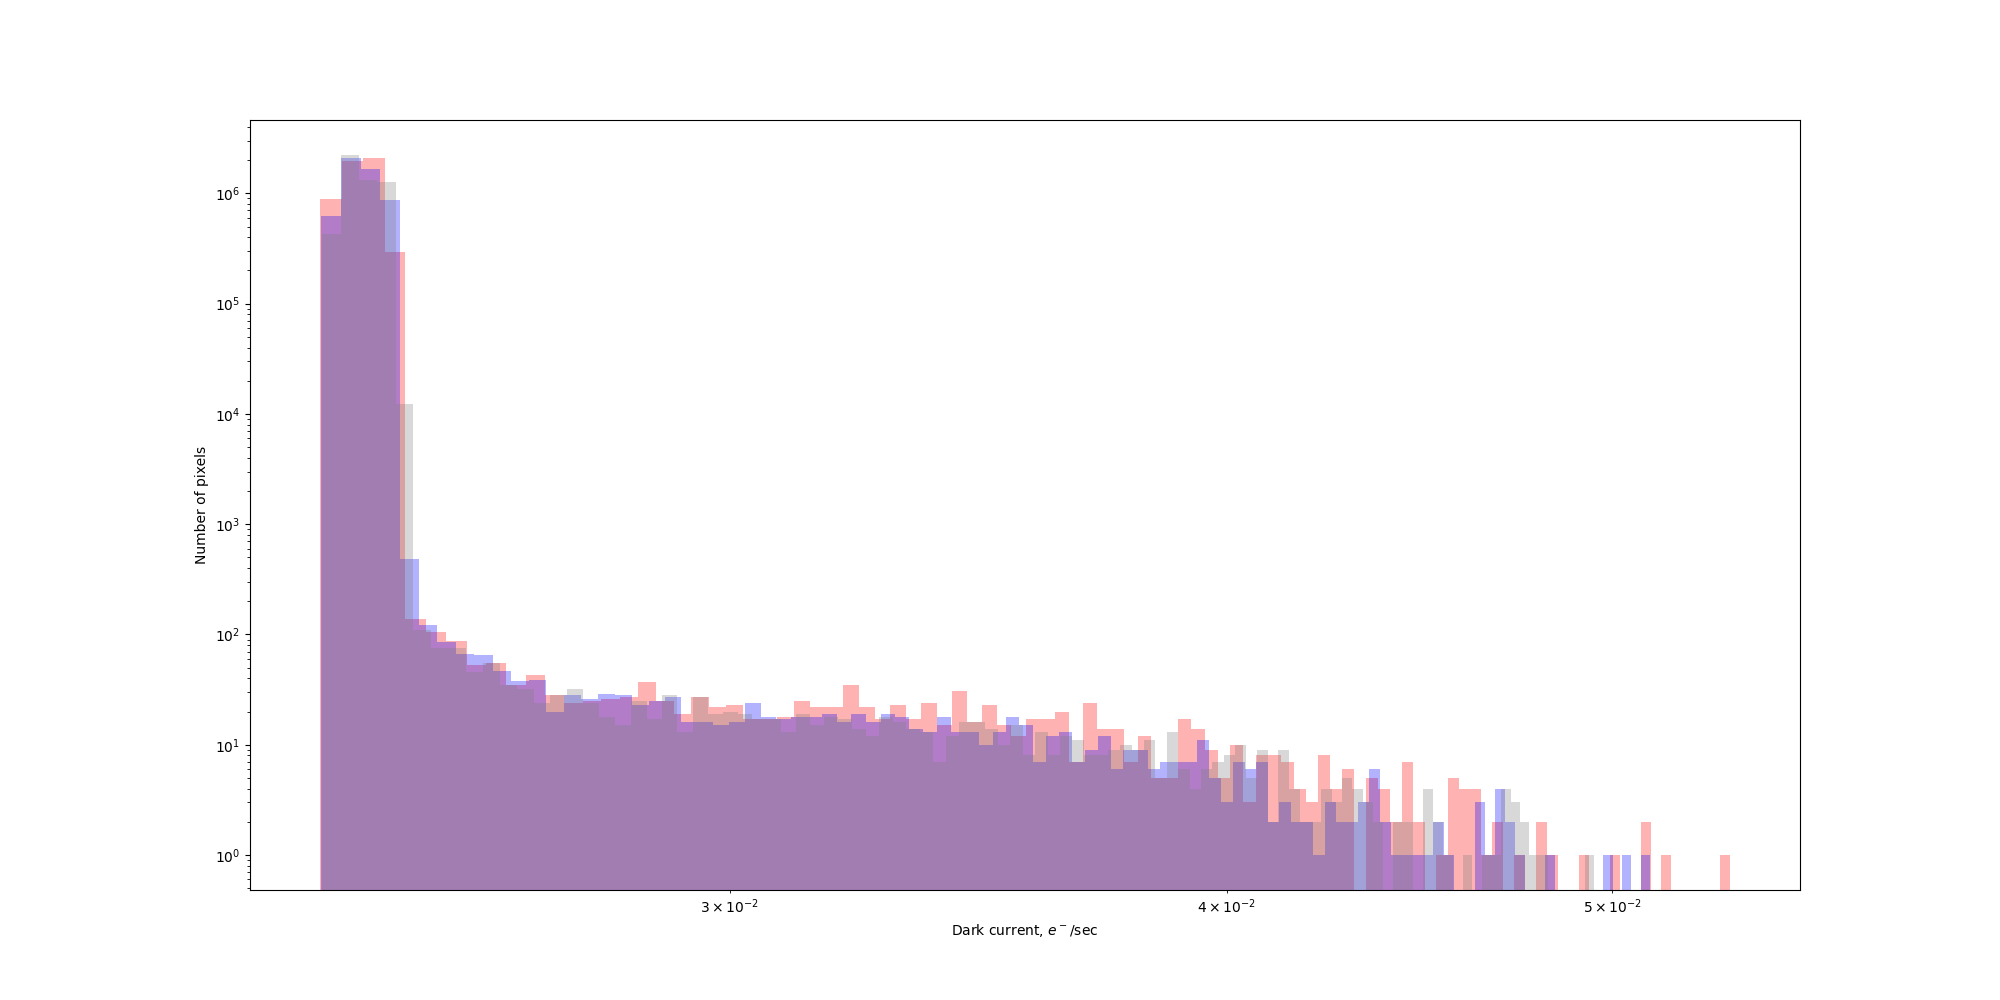

In [97]:
# Plot a histogram of dark currents.
plt.figure(figsize = (20,10))
num = 1
colors = ['red', 'blue', 'gray']
for dark_cur in dark_current_list:
  plt.hist(dark_cur.flatten(), bins = 100, density = False, color = colors[num - 1], alpha = 0.3)
  num += 1
plt.xlabel('Dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()

**Plotting hot pixels from one dark frame against another.**

---
*Ideally, the user should have 2 combined dark frames with 2 different exposure times. According to the histogram, the user should set the boundary for hot pixels where the dark frame with the lowest dark current exceeds the value where the "tail" of the histogram "diverges".*

In the data used in this pipeline, only 1 combined dark frame exists because three darks with the same exposure time were taken during 1 night.

Therefore, the accurate analysis of hot pixels cannot be conducted with this data, but it will be used to show the user how to conduct this analysis correctly.

In [98]:
# Defining preliminary hot pixels.
hot_pixels = (dark_current_list[0] > 0.001 * u.electron /(u.adu * u.s))

**Comparing the data from first and second dark images in the list.**

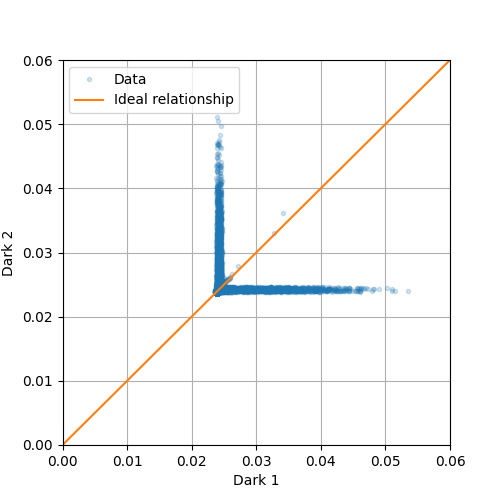

In [99]:
plt.figure(figsize = (5, 5))
plt.plot(dark_current_list[0][hot_pixels].flatten(), dark_current_list[1][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 1")
plt.ylabel("Dark 2")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.grid()
plt.xlim(0, 0.06)
plt.ylim(0, 0.06)
plt.legend()

**Comparing the data from first and third dark images in the list.**



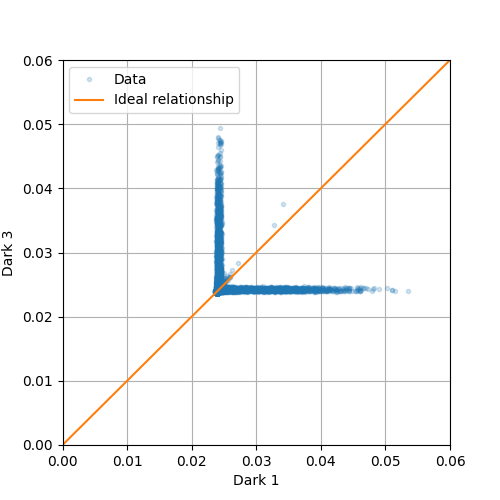

In [100]:
plt.figure(figsize = (5,5))
plt.plot(dark_current_list[0][hot_pixels].flatten(), dark_current_list[2][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 1")
plt.ylabel("Dark 3")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.xlim(0, 0.06)
plt.ylim(0, 0.06)
plt.grid()
plt.legend()

**Comparing the data from second and third dark images in the list.**

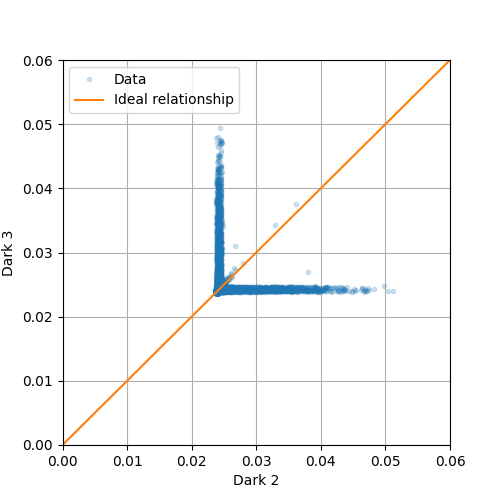

In [101]:
plt.figure(figsize = (5,5))
plt.plot(dark_current_list[1][hot_pixels].flatten(), dark_current_list[2][hot_pixels].flatten(), '.', alpha = 0.2,
         label = 'Data')
plt.xlabel("Dark 2")
plt.ylabel("Dark 3")
plt.plot([0, 100], [0, 100], label = 'Ideal relationship')
plt.xlim(0, 0.06)
plt.ylim(0, 0.06)
plt.grid()
plt.legend()

**At this point, it is best to turn off interactivity.**

In [102]:
%matplotlib inline

### **Final choice of Pixels.**

---
According to the plot of hot pixels, the user should set the boundary for hot pixels where the dark frame with the highest dark current exceeds the value where the "bubbles" "diverge".

In the data used in this pipeline, the "bubbles" diverge right away, which is expected because three darks with the same exposure time taken during 1 night are used intead of 2 combined dark frames with 2 different exposure times.

*Therefore, the user should not pay attention to these results.*

In [103]:
bad_hot_pixels = (dark_current_list[0] > 0.0231 * u.electron /(u.adu * u.s))
bad_hot_pixels.sum()

5267456

### **Preparing the bad hot pixels for masking.**

---
Converting the array of hot pixels into array of boolean values. Inverting the resulting mask so that True (or 1) values become False (or 0) so that when applying the mask the hot pixels are multiplied by 0 and hence get masked.

In [104]:
bad_hot_pixel_mask = bad_hot_pixels.astype('bool')
inv_bad_hot_pixel_mask = (bad_hot_pixel_mask - 1) * (-1)

## **Bad Pixel Mask.**

---
Creating an array of calibrated (bias-subtracted) red flats to work with.

This block of code subtracts bias from each flat file, writes the calibrated
flat frames into text file "redflatlist_cal.txt", and saves them in the directory provided by the user in the "darkcombine" function. The user should use path to the combined bias frame when subtracting bias.

In [105]:
with open('redflatlist_cal.txt', 'w') as f:
      count = 1
      for redflatfile in redflatfiles:
        calibrated_redflatfile = fits.getdata(redflatfile)
        - fits.getdata("/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037/bias_combined.fits")
        f.write("calibrated_redflatfile{}.fits".format(count) + "\n")
        filename = "calibrated_redflatfile{}.fits".format(count)
        hdu = fits.PrimaryHDU(calibrated_redflatfile)
        hdu.writeto(path/filename, overwrite = True)
        count += 1
# Read the text file into a table, the list of column names to use has only one name, "impath".
# Returning an array of the calibrated flat frames.
redflatfilescal_i = pd.read_table("redflatlist_cal.txt", names = ['impath'])
redflatfilescal = directory_new +'/'+ redflatfilescal_i['impath'].values
redflatfilescal

array(['/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037//calibrated_redflatfile1.fits'],
      dtype=object)

**This block of code calculates and prints out mean counts in each calibrated flat file.**

In [106]:
for redflat in redflatfilescal:
  hdul = fits.open(redflat)
  mean_counts = np.mean(hdul[0].data)
  print(mean_counts)

6315.400320042445


### **Checking Mean**

* If the mean counts are very similar in each flat frame, the mask needs to be
build using any one of the frames.

* If they are very different, a ratio of the flats with the highest and lowest masks should be used.

In this pipeline, the mask is created using one of the flats, because the mean counts are very similar in each flat frame.

#### **The block below appends "EXPTIME" keyword to the header of the file containing a single calibrated flat frame (the user can pick any of the flat frames being used).**
Appending "EXPTIME", which has the same value as that of the raw flat frame provided by the user.

In [107]:
flat_orig = fits.open("/content/drive/MyDrive/RAISE Student Research/UT230909/Flat_SEG3R1.0039.fits")
header = flat_orig[0].header
exptime = header['EXPTIME']
flat_tobetrimmed = "/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037/calibrated_redflatfile1.fits"
hdul = fits.open(redflatfilescal[0], 'update')
hdr = hdul[0].header
hdr.append("DATASEC")
hdr["DATASEC"] = "[1:2048,1:4096]"
hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
hdr.append("EXPTIME")
hdr["EXPTIME"] = exptime
hdul.writeto(flat_tobetrimmed, overwrite = True)
# Trimming the bias and not illuminated sections of the calibrated flat frame so that
# it has the same size as the reduced science image.
trimmed_flat = pipe.apo_proc(flat_tobetrimmed, ilum=redilum_darknotsub, Saxis = 1, Waxis =0)

## **Creating the Mask.**

In [108]:
# Printing the wall time for the entire cell (CPU times and Wall time).
%%time
import ccdproc as ccdp
# Creating the mask.
mask = ccdp.ccdmask(trimmed_flat)

CPU times: user 42.9 s, sys: 65.3 ms, total: 43 s
Wall time: 43.2 s


**Inverting the mask so that False (or 0) values become True (or 1) so that when applying the mask the bad pixels are multiplied by 0 and hence get masked. (The mask encodes good pixels with False (or 0) and bad with True (or 1)).**

In [109]:
inv_mask = (mask - 1) * (-1)

## **Masking the Science Image**

---
Applying the mask(s) to the science image and eliminating cosmic rays. The user should apply either hot pixel mask, or bad pixel mask, or both based on his/her data. The mask that has larger size should be applied first.

If the user only needs to use one of the masks, he/she should simply multiply the mask by the science image.
- Ex. 1 (applying the hot pixel mask only): `sciimg_masked = sciimg * inv_bad_hot_pixel_mask`
- Ex. 2 (applying the bad pixel mask only): `sciimg_masked = sciimg * inv_mask`

Please be sure to find your own telescope's saturation level for cosmic rays mask.

**"sigclip" is the parameter with the most direct effect on how many cosmic rays are found and masked.**

*If the user feels as though this version hasn't found enough cosmic rays (there are still visible defects), he/she needs to lower the value of "sigclip". If the user feels that the mask caught things that are not cosmic rays, then he/she should increase the value of "sigclip" to mask fewer pixels.*

In [110]:
%matplotlib inline
combined_mask = inv_mask | inv_bad_hot_pixel_mask
sciimg_masked = sciimg * combined_mask
# Multiplying the masked science image data by gain.
sciimg_masked_gaincorr = sciimg_masked.data * gain * u.electron/u.second
# Creating cosmic ray mask.
cosmic_mask = ccdp.cosmicray_lacosmic(sciimg_masked_gaincorr, sigclip = .01, readnoise = read_noise, gain = gain,
                                      satlevel = 262000, niter = 5, verbose = True)
# Inverting the mask.
inv_cosmic_mask = ~cosmic_mask[1]
# Applying the cosmic ray mask to the masked science image.
final_sciimg = sciimg_masked * inv_cosmic_mask

Starting 5 L.A.Cosmic iterations
Iteration 1:
1387 cosmic pixels this iteration
Iteration 2:
16 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration


### **Plotting the resulting masked science image.**

---
**Due to a characteristic of widget that was being disabled earlier, please make sure to run this block of code twice. Otherwise all pictures that were plotted when widget was enabled would be shown (instead of just one intended in this block of code).**

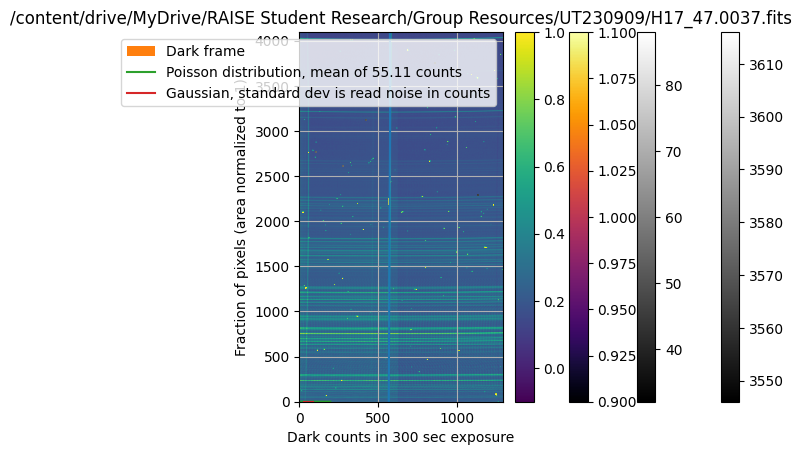

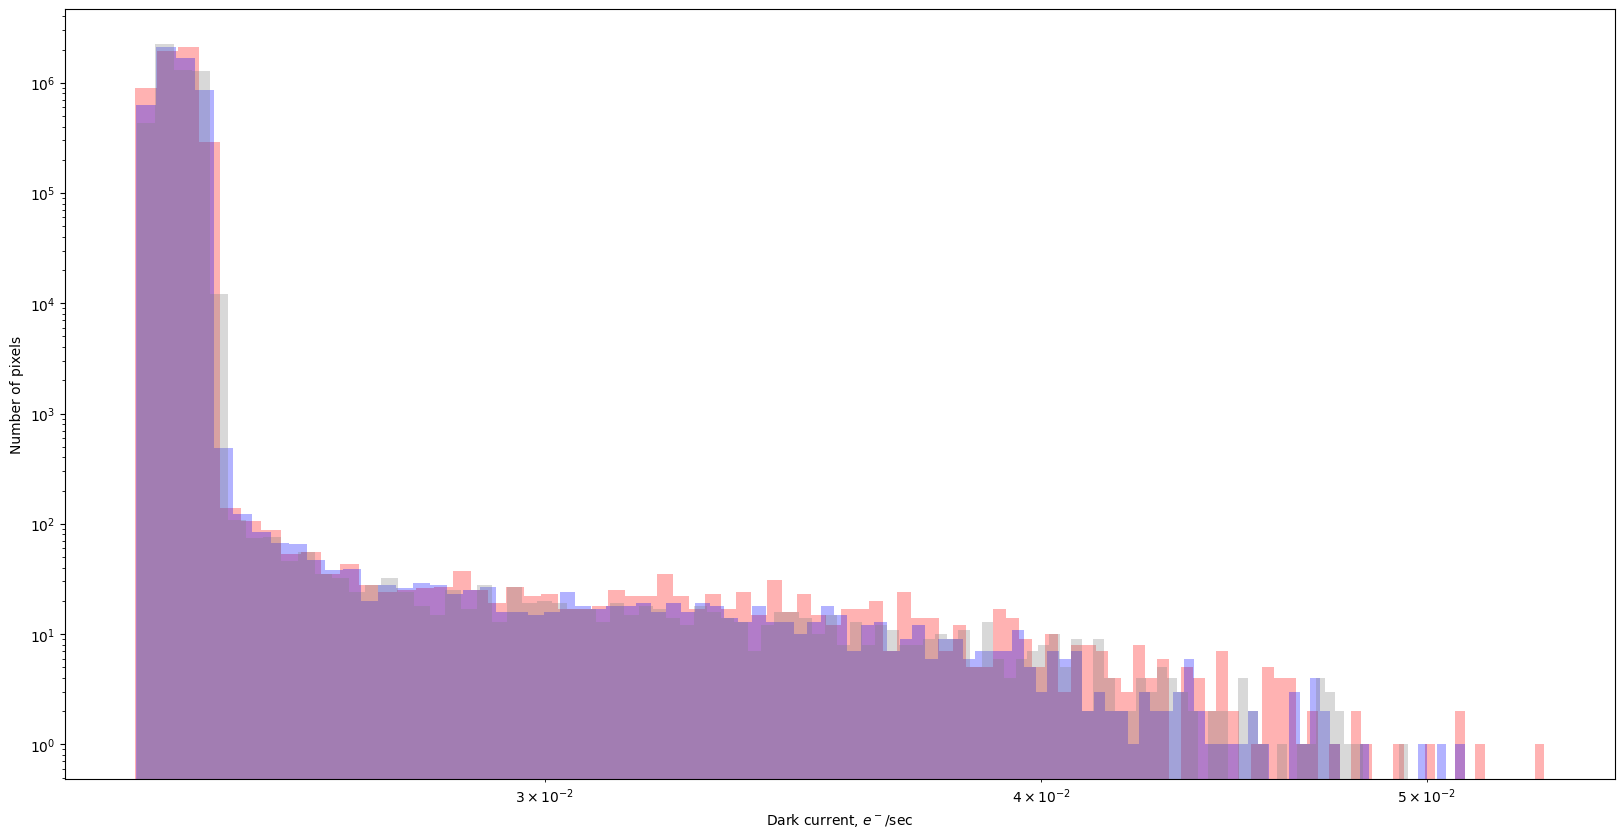

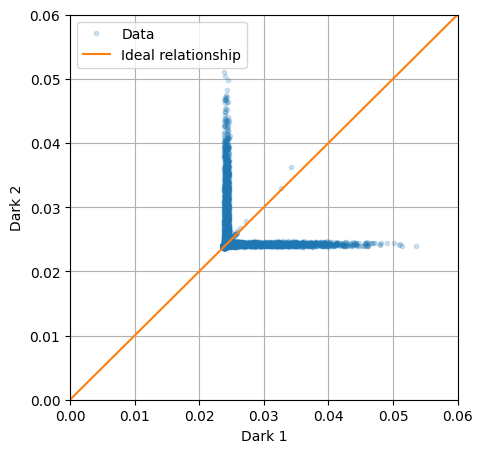

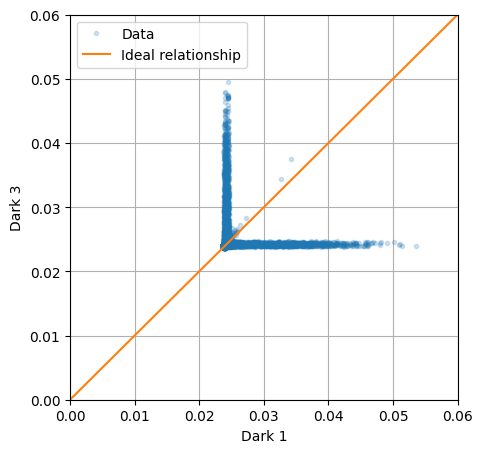

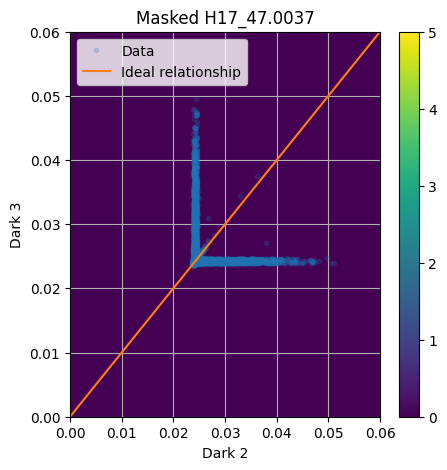

In [111]:
plt.imshow(final_sciimg, origin='lower', aspect='auto')
cb = plt.colorbar()
plt.clim(0,5)
plt.title("Masked H17_47.0037")
plt.show()

**Printing the final science image shape.**

In [112]:
print(final_sciimg.shape)

(4096, 1286)


## **Trace for our star.**

---
Tracing star spectrum using Jim Davenport's `"kosmos.trace"` function in the science image and displaying the result.

*Use zoom provided by widget to ensure tracing accuracy and change "guess", "window", and "nbins" as needed to achieve quality fit.*

<ipython-input-113-925c113a4928>:2: DeprecationWarning: PyKOSMOS trace is now a wrapper for functions within specreduce.tracing, and is kept for backwards compatibility. More features are available from specreduce.tracing.
  sci_trace = pykosmos.trace(final_sciimg, display = True, guess = 559,
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


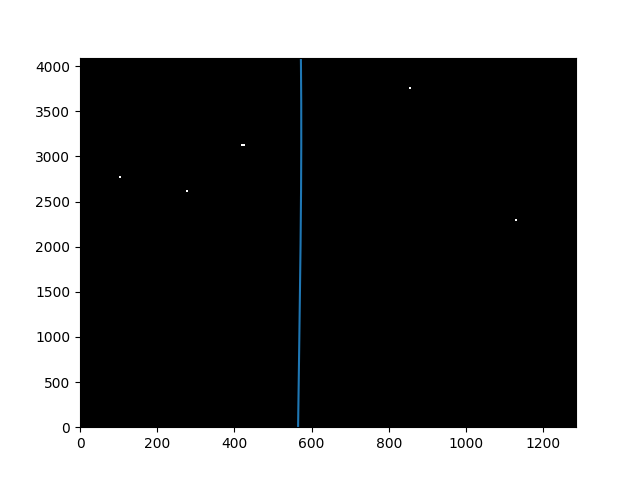

In [113]:
%matplotlib widget
sci_trace = pykosmos.trace(final_sciimg, display = True, guess = 559,
                           window = 15, nbins = 20, Saxis = 1, Waxis = 0)

## **BoxcarExtract for our star.**

---
Converting the masked science image into CCDData object (because the following function takes CCDData object as a parameter).

Using Jim Davenport's "kosmos.BoxcarExtract" function to extract spectrum from  the science image from above and displaying the result.

*Use zoom provided by widget to ensure accurate spectrum extraction.
Change "apwidth", "skysep", and "skywidth" as needed.*

In [114]:
sciimg.unit = u.adu/u.s
sciimg.unit

Unit("adu / s")

/content/cofi-kosmos-pipe-funcs/CofI_KOSMOS/apextract_re.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


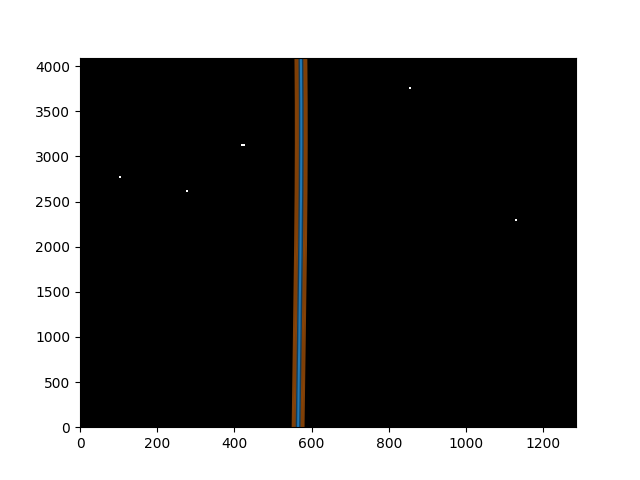

In [115]:
ccd_final_sciimg = CCDData(final_sciimg, wcs = sciimg.wcs, unit =sciimg.unit)
# Extracting spectrum from one star.
sci_ex, sci_sky= pipe.BoxcarExtract(ccd_final_sciimg, sci_trace, display = DISPLAY, apwidth = 4,
                                       skysep = 5, skywidth = 5, Saxis = 1, Waxis = 0)

### **Plotting a graph of counts vs. pixels in the science image.**

---
**Due to a characteristic of widget that was being disabled earlier, please make sure to run this block of code twice. Otherwise all pictures that were plotted when widget was enabled would be shown (instead of just one intended in this block of code).**

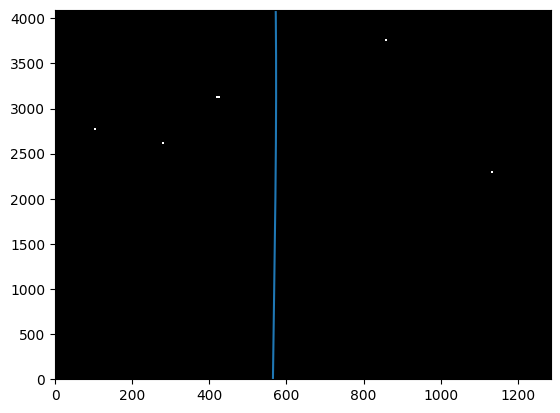

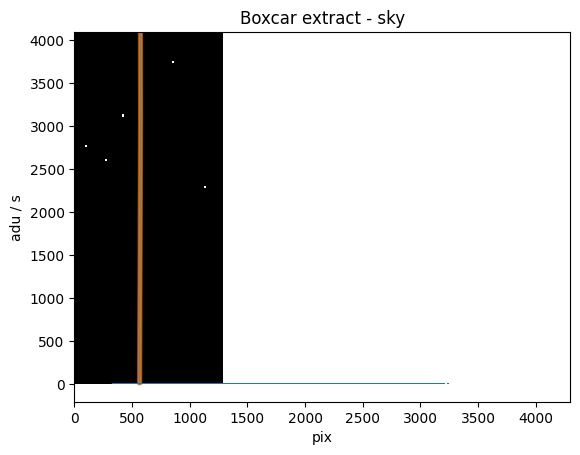

In [116]:
%matplotlib inline
if DISPLAY:
    plt.errorbar(sci_ex.spectral_axis.value, sci_ex.flux.value - sci_sky.flux.value,
                 yerr = sci_ex.uncertainty.array, linestyle = 'none')
    plt.xlabel(sci_ex.spectral_axis.unit)
    plt.ylabel(sci_ex.flux.unit)
    plt.title('Boxcar extract - sky')
    plt.show()

## **Respective Neon Lamp processed with "apo_proc".**

---
Opening an ARC LAMP. Appending "DATASEC" keyword to its header. Applying some basic processing to it and displaying it.

**Use the arc lamp that corresponds to science image in terms of
grism color, slit position, and exposure time.**

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:overwriting masked ndarray's current mask with specified mask.


INFO: overwriting masked ndarray's current mask with specified mask. [astropy.nddata.nddata]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


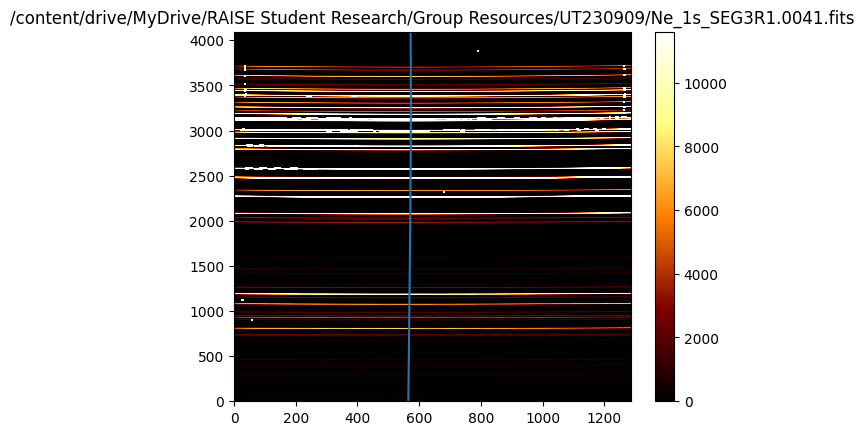

In [117]:
%matplotlib inline
# Opening an arc lamp.
arcfile = directory_orig + 'Ne_1s_SEG3R1.0041.fits'
# Appending "DATASEC" keyword to the header of the arc lamp file.
hdul = fits.open(arcfile, 'update')
hdr = hdul[0].header
hdr.append("DATASEC")
hdr["DATASEC"] = "[1:2048,1:4096]"
hdr.comments["DATASEC"] = "data section of CCD (unbinned)"
hdul.writeto(arcfile, overwrite = True)
# Using "apo_proc" function defined above to reduce the arc lamp image.
arcimg = pipe.apo_proc(arcfile, bias = bias, ilum = redilum_darknotsub, Saxis = 1, Waxis = 0)
# Plotting the resulting arc lamp image.
if DISPLAY:
    plt.imshow(arcimg, origin ='lower', aspect ='auto', cmap = plt.cm.afmhot)
    plt.plot(sci_trace, np.arange(len(sci_trace))) # for illustration, overplot the trace
    plt.clim(np.percentile(arcimg, (5,97)))
    cb = plt.colorbar()
    plt.title(arcfile)
    plt.show()

### **Plot of Neon Wavelengths.**

---
For the data used in this pipeline, wavelengths for neon lamp with red grism, center slit, and 2 sec exposure time are used.

*The user needs to reference a plot with labeled wavelengths that will match the data under consideration. This plot can be found in the instrument documentation.*

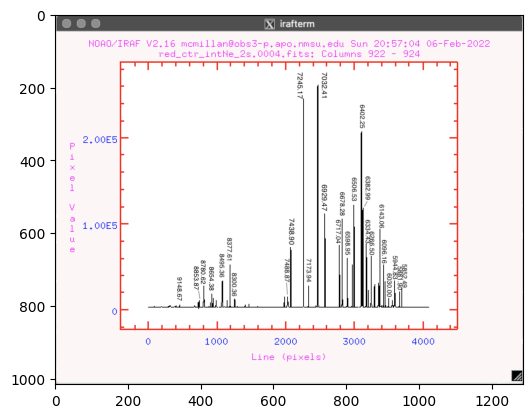

In [118]:
# Once you have the image file from calibration lamp, you need to be able to look at the reference plot
# with labeled wavelengths from APO KOSMOS documentation.
# The plot is included here, but it might be easier to just have it open in another tab or document.
img = plt.imread("/content/drive/MyDrive/RAISE Student Research/Group Resources/Notebooks/czeyrw1x.png")
Neref = plt.imshow(img)

## **BoxcarExtract for respective Neon Lamp and trace from the star.**

---
Using Jim Davenport's `"pykosmos.BoxcarExtract"` function to extract spectra across the arc lamp image.

In [119]:
sciarc_ex, _ = pipe.BoxcarExtract(arcimg, sci_trace, apwidth = 3, skysep = 5, skywidth = 5, Saxis = 1, Waxis = 0)
'''# Plotting a graph of counts vs. pixels in the arc lamp image.
if DISPLAY:
    plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)
    plt.xlabel(sciarc_ex.spectral_axis.unit)
    plt.ylabel(sciarc_ex.flux.unit)'''

'# Plotting a graph of counts vs. pixels in the arc lamp image.\nif DISPLAY:\n    plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)\n    plt.xlabel(sciarc_ex.spectral_axis.unit)\n    plt.ylabel(sciarc_ex.flux.unit)'

## **Wavelength calibration for the star.**

---
Using the modified version of Jim Davenport's pykosmos function, `"pipe.identify_widget"`(modified in cofi_kosmos_pipe_funcs).

*The instructions will pop up with the widget telling you how to use it.*

- For this process specifically, you need to look at the wavelengths on the reference picture from APO and find wavelengths that match.
- Then you click on the line in the picture that matches and type in what wavelength it is supposed to be.
- Try to match 5 or 6, from different parts of the image.


    Instructions:
    ------------
    0) For proper interactive widgets, ensure you're using the Notebook backend
    in the Jupyter notebook, e.g.:
        %matplotlib notebook
    1) Click on arc-line features (peaks) in the plot. The Pixel Value box should update.
    2) Select the known wavelength of the feature in the Wavelength box.
    3) Click the Assign button, and a red line will be drawn marking the feature.
    4) When you've identified all your lines, stop the interaction for (or close) the figure.


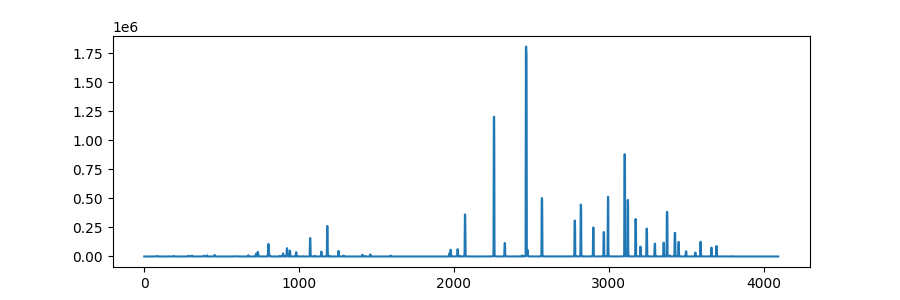

In [120]:
%matplotlib notebook
sci_xpts_ne, sci_wpts_ne = pipe.identify_widget(sciarc_ex)

**Copying & pasting the "sci_xpts_ne" and "sci_wpts_ne" that the cell above outputs.**

Need to use the last line of the output only. The first list has "sci_xpts_ne" - x-points, the second list has "sci_wpts_ne" - wavelengths.

This is done to avoid working on the cell above more than once, which saves time.

In [121]:
sci_xpts_ne = [2467.1978658056723, 2259.0395243822018, 1182.5086779291735, 1071.7795645404506, 802.844415409455]

In [122]:
sci_wpts_ne = [7032.41, 7245.17, 8377.61, 8495.36, 8780.62]

In [123]:
'''sci_xpts, sci_wpts = pipe.wave_cal(base_file= 'apox_neon_xpoints.dat',neon_spectra=sciarc_ex,standardize_wave_file='copy_new_neon_red_center.dat',
                                      poly =3, autotol_value = 25, npixels=1)'''

"sci_xpts, sci_wpts = pipe.wave_cal(base_file= 'apox_neon_xpoints.dat',neon_spectra=sciarc_ex,standardize_wave_file='copy_new_neon_red_center.dat',\n                                      poly =3, autotol_value = 25, npixels=1)"

### **Checking the validity of guessed x-points.**

---
Now that we have the list of guessed x-points and their related wavelength values, we can use the following method to make sure our guessed x-points are actually right on the peak of the wavelength.

[<Quantity 2466.49948545 pix>, <Quantity 2258.49993142 pix>, <Quantity 1181.52037149 pix>, <Quantity 1070.56118184 pix>, <Quantity 801.57421877 pix>]
[2467.1978658056723, 2259.0395243822018, 1182.5086779291735, 1071.7795645404506, 802.844415409455]


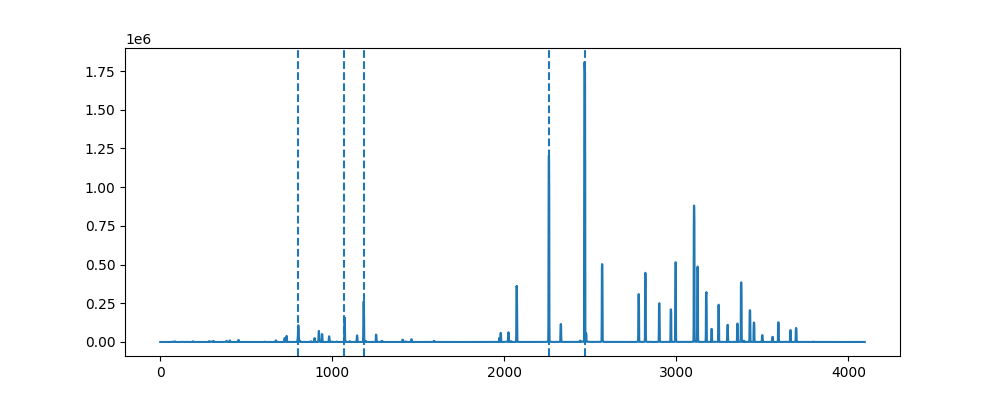

In [124]:
npixels = 1   # This is the area around your guess that the new approximation will search for a peak within.
axis = sciarc_ex.spectral_axis
ne_spectrum = sciarc_ex.flux
# In order for the indexing to work in the next step,
# we need to make a list of the nearest integer to our guessed "xpts".
integer_xpts = []
for x in sci_xpts_ne:
  integer_xpts.append(int(x - x % 1))
improved_xpts = [np.average(axis[g - npixels:g + npixels],weights = ne_spectrum[g - npixels:g + npixels]
                            - np.median(ne_spectrum)) for g in integer_xpts]
# Print improved and original "xvals" to compare:
print(improved_xpts)
print(sci_xpts_ne)
# Checking how well it lines up:
plt.figure(figsize = (10, 4))
plt.plot(sciarc_ex.spectral_axis, sciarc_ex.flux)
for val in improved_xpts:
  plt.axvline(x = val.value, ls = '--')

Preparing wavelength data for Jim Davenport's modified `"pipe.identify_nearest"` function that will identify more wavelengths using arc lamp lines.

In [125]:
sci_wpts_ne = sci_wpts_ne *  u.angstrom   # Make sure you only run this line once.
xpts_values = []
for val in improved_xpts:
  xpts_values.append(val.value)
print(xpts_values)
print(sci_wpts_ne)
# Sort, just in case.
srt = np.argsort(xpts_values)
xpt = np.array(xpts_values)[srt]
wpt = np.array(sci_wpts_ne)[srt]
print(wpt)
fit = np.polyfit(xpt, wpt, deg = 3)
wavesolved = np.polyval(fit, sciarc_ex.spectral_axis.value)
print(wavesolved)

[2466.4994854455686, 2258.4999314161446, 1181.5203714942168, 1070.5611818376292, 801.5742187651217]
[7032.41 7245.17 8377.61 8495.36 8780.62] Angstrom
[8780.62 8495.36 8377.61 7245.17 7032.41]
[9616.73150569 9615.70934639 9614.68711963 ... 5517.07124515 5516.24887263
 5515.42666526]


####**Preparing a table of strong emission lines.**

For the data used in this pipeline, wavelengths for neon lamp with red grism, center slit, and 2 sec exposure time are used. The user needs to reference a plot with labeled wavelengths that will match the data under consideration. This plot can be found in the instrument documentation.

In [126]:
# Use a table of strong emission lines with units.
# This table can be constructed using appropriate for the data under consideration reference plot
# with labeled wavelengths from APO KOSMOS documentation.
henear_tbl = Table.read('/content/drive/MyDrive/RAISE Student Research/Group Resources/copy_new_neon_red_center.dat',
                        names = ('wave', 'name'), format = 'ascii')
henear_tbl['wave'].unit = u.angstrom
apo_henear = henear_tbl['wave']

### **Assigning as many wavelengths as possible.**

---
Using modified version of Jim Davenport's `"pipe.identify_nearest"` function to match and assign more wavelengths referencing the plot of the wavelengths at rest.

The *autotol* parameter can be adjusted as needed to ensure the best fit.

In [127]:
sci_xpts, sci_wpts = pipe.identify_nearest(sciarc_ex, wapprox = wavesolved * u.angstrom,
                                             linewave = apo_henear, autotol=25)

24 lines matched from 30 within estimated range.


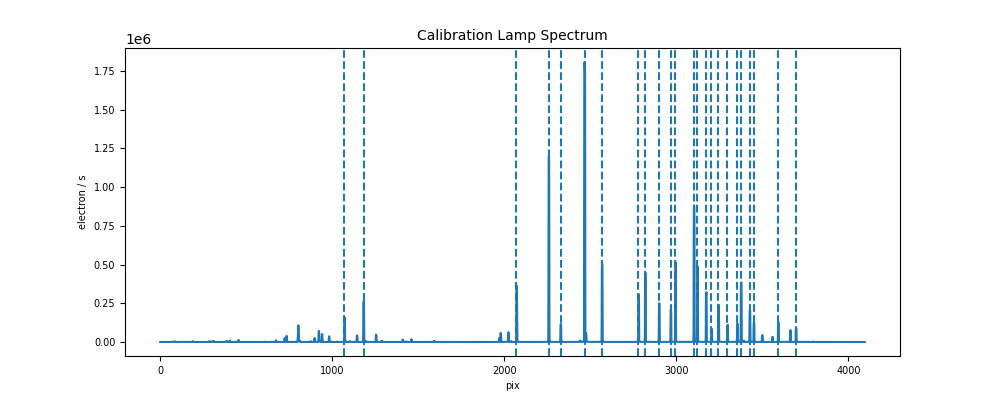

In [128]:
# Now that we have our final list of guessed x-points and their related wavelength values,
# we can use the following method to make sure our guessed x-points are actually right on the peak of the wavelength.
integer_xpts_new = []
for x in sci_xpts:
  integer_xpts_new.append(int(x - x % 1))
improved_xpts_new = [np.average(axis[g - npixels:g + npixels], weights = ne_spectrum[g - npixels:g + npixels]
                                - np.median(ne_spectrum)) for g in integer_xpts_new]
# Checking how well it lines up:
plt.figure(figsize = (10, 4))
plt.plot(sciarc_ex.spectral_axis, sciarc_ex.flux)
plt.title(label = "Calibration Lamp Spectrum", fontfamily = 'sans-serif', fontsize = 10.0)
plt.xlabel(sciarc_ex.spectral_axis.unit, fontsize = 7)
plt.ylabel(sciarc_ex.flux.unit, fontsize = 7)
plt.xticks(fontfamily = 'sans-serif',fontsize = 7)
plt.yticks(fontfamily = 'sans-serif',fontsize = 7)
for val in improved_xpts_new:
  plt.axvline(x = val.value, ls = '--')
# Updating "xpts_values":
xpts_values_new = []
for val in improved_xpts_new:
  xpts_values_new.append(val.value)

### **Checking the quality of wavelength calibration.**

Please use zoom provided by widget to look closely at the prominent troughs and compare those wavelength values with those on the reference plots on this website: http://www.astrosurf.com/buil/us/vatlas/vatlas.htm.

**If the difference is less than 1 Angstrom, the wavelength calibration should be reliable.**

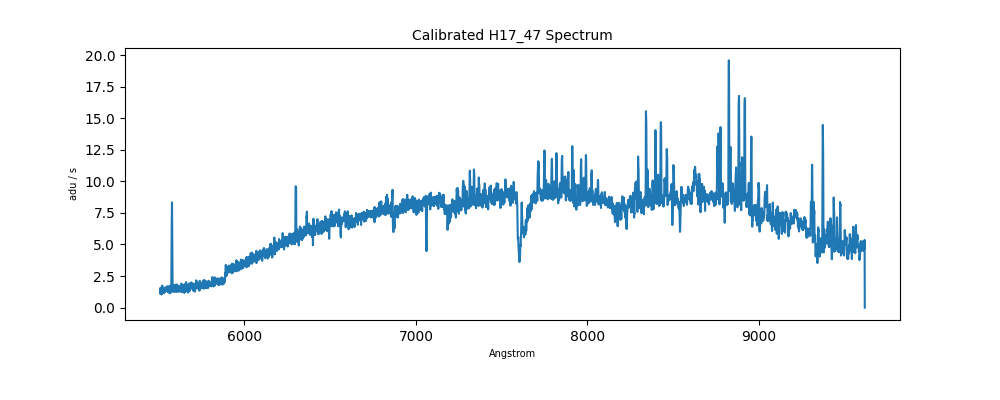

In [129]:
# Plotting the spectrum (sky is not subtracted).
sci_fit_check = pykosmos.fit_wavelength(sci_ex, xpts_values_new, sci_wpts, mode='poly', deg=3)
plt.figure(figsize = (10,4))
plt.plot(sci_fit_check.spectral_axis, sci_fit_check.flux)
plt.title("Calibrated H17_47 Spectrum", fontsize = 10)
plt.xlabel( sci_fit_check.spectral_axis.unit, fontsize = 7)
plt.ylabel(sci_fit_check.flux.unit, fontsize = 7)
plt.subplots_adjust(bottom = 0.2)
plt.show()

Subtracting sky from the actual spectrum, fitting the wavelength solution, plotting the resulting graph.

**Note that we could only use flux axis to perform subtraction: Python gives an error otherwise, because it doesn't want to deal with pixels, and the other axis is in pixels. This is the best and final fit. This spectrum can now be used for scientific analysis.**

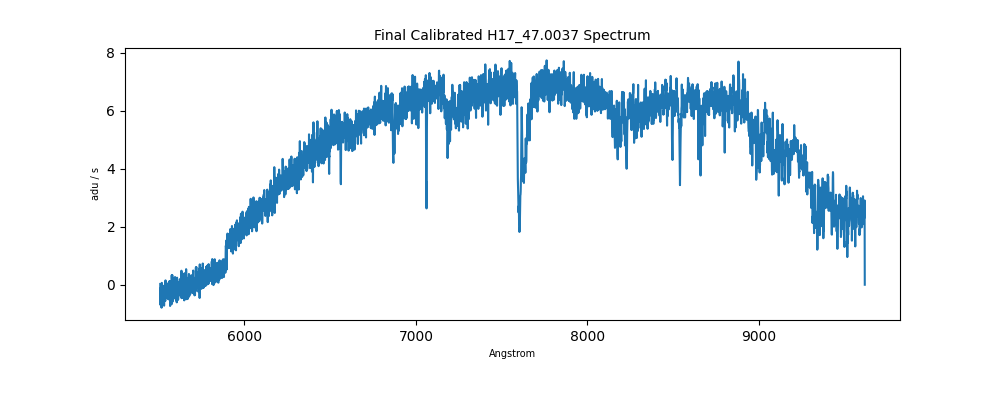

In [134]:
# Make the "sci_spectrum" using the material from "kosmos.trace" and "kosmos.BoxcarExtract" functions.
sci_spectrum = sci_ex.flux - sci_sky.flux
sci_spec = Spectrum1D(flux = sci_spectrum, spectral_axis = sci_ex.spectral_axis, uncertainty = sci_ex.uncertainty)
# And then input it into Jim Davenport's "kosmos.fit_wavelength" function.
sci_fit_final = pykosmos.fit_wavelength(sci_spec,xpts_values_new, sci_wpts, mode ='poly', deg = 3)
# Save the final spectrum. Please make sure to use "tabular-fits" format.
sci_fit_final.write('/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037 Spectrum', overwrite = True,
                    format = 'tabular-fits')
plt.figure(figsize = (10,4))
plt.plot(sci_fit_final.spectral_axis, sci_fit_final.flux)
plt.title("Final Calibrated H17_47.0037 Spectrum", fontsize = 10)
plt.xlabel( sci_fit_final.spectral_axis.unit, fontsize = 7)
plt.ylabel(sci_fit_final.flux.unit, fontsize = 7)
plt.subplots_adjust(bottom = 0.2)
plt.show()